# Results

| **avg accuracy**    | logistic | xgboost |
|---------------------|----------|---------|
| per file            | 0.66     | 0.57    |
| train all, test one | 0.58     | 0.54    |
| train one, test all | 0.53     | 0.58    |

In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from util.rank_metrics import mean_average_precision
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

from sklearn.model_selection import LeaveOneOut

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
xgb.set_config(verbosity=1)

#
from util.Util import plot_accuracies, read_csv
from df_features import DataFrameFeatures
from df_classifier import DataFrameClassifier

file_names = ['Computer vision','Consulting','Fintech','Fish processing equipment','Healthcare','House builders','Industrial vertical investor','Innovative','IoT','IT freelance','M&A advisors','Manufacturers','Online games','Payments tech','PE fund','Procurement software','Resource-efficiency','SaaS','Sustainability','Wind turbine tech']

In [2]:
# Read GLOVE embeddings from file
glove_df = read_csv('util/glove/glove.42B.300d.txt', sep=" ", index_col=0, quoting=3, header=None)
glove_embeddings = {key: val.values for key, val in tqdm(glove_df.T.items())}
del glove_df # Delete glove_df to free up memory

* Reading CSV from path: util/glove/glove.42B.300d.txt. Size: (1917494, 300)


1917494it [00:23, 81279.83it/s]


In [3]:
np.random.seed(0)

# Read the cleaned dataframe
full_df = read_csv('data/processed_data/cleaned_v1.csv')

# Create tf-idf vectorizer using the main col and a max of 250 features
main_col = 'description_no_stopwords'
vectorizer = TfidfVectorizer(max_features=50, analyzer='char')
vectorizer.fit_transform(full_df[main_col])

full_dff = DataFrameFeatures(df=full_df, vectorizer=vectorizer, main_col=main_col, verbose=False)

* Reading CSV from path: data/processed_data/cleaned_v1.csv. Size: (60122, 7)


# Classification

## Leave one out

### Logistic | Leave one out per file

In [196]:
mcnemar = {}
names = {}

# Calculate the accuracies
for i, file_name in tqdm(enumerate(file_names)):

    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    # X, y = dfc.get_tfidf_vectors()
    X, y = dfc.get_feature_vectors()
    
    loo = LeaveOneOut()

    mcnemar[file_name] = []

    clf = LogisticRegression(random_state=0, class_weight='balanced')

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        correct_classification = (y_test == clf.predict(X_test)).astype(int).astype(str)
        mcnemar[file_name].extend(correct_classification)

# Accuracy
flat = [int(x) for x in list(mcnemar.values()) for x in x]
accuracy = sum(flat) / len(flat)
print(f"Logistic Accuracy tfidf vectors: {accuracy}")

#Logistic Accuracy Feature vectors: 0.5809294871794872
#Logistic Accuracy tfidf vectors: 0.6049679487179487


20it [00:28,  1.44s/it]

Logistic Accuracy tfidf vectors: 0.5809294871794872


In [197]:
print([sum([int(y) for y in x]) / len(x) for x in mcnemar.values()])

[0.6052631578947368, 0.6721311475409836, 0.7014925373134329, 0.5652173913043478, 0.6666666666666666, 0.6071428571428571, 0.4782608695652174, 0.5263157894736842, 0.6612903225806451, 0.45901639344262296, 0.6607142857142857, 0.5, 0.7166666666666667, 0.6142857142857143, 0.6176470588235294, 0.3770491803278688, 0.6142857142857143, 0.5454545454545454, 0.52, 0.44642857142857145]


In [24]:
import json
with open('data/mcnemar/mcnemar_custom_names.json', 'w') as fp:
    json.dump(names, fp)

### XGBoost | Leave one out per file

In [201]:
mcnemar = {}

# Calculate the accuracies
for i, file_name in tqdm(enumerate(file_names)):

    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X, y = dfc.get_tfidf_vectors()
    # X, y = dfc.get_feature_vectors()

    loo = LeaveOneOut()

    mcnemar[file_name] = []

    xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='map')

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        xg.fit(X_train, y_train)
        correct_classification = (y_test == xg.predict(X_test)[0]).astype(int).astype(str)
        mcnemar[file_name].extend(correct_classification)

# Accuracy
flat = [int(x) for x in list(mcnemar.values()) for x in x]
accuracy = sum(flat) / len(flat)
print(f"XGBoost Accuracy feature vectors: {accuracy}")

#XGBoost Accuracy tfidf vectors: 0.6666666666666666
#XGBoost Accuracy feature vectors: 0.6610576923076923

20it [00:37,  1.89s/it]

XGBoost Accuracy feature vectors: 0.6666666666666666


In [203]:
print([sum([int(y) for y in x]) / len(x) for x in mcnemar.values()])

[0.47368421052631576, 0.6229508196721312, 0.7164179104477612, 0.7536231884057971, 0.6444444444444445, 0.6071428571428571, 0.5652173913043478, 0.5394736842105263, 0.8548387096774194, 0.5245901639344263, 0.5, 0.4583333333333333, 0.8833333333333333, 0.8142857142857143, 0.8823529411764706, 0.7540983606557377, 0.7571428571428571, 0.7818181818181819, 0.74, 0.6071428571428571]


In [95]:
import json
with open('data/mcnemar/xgboost_mcnemar_custom.json', 'w') as fp:
    json.dump(mcnemar, fp)

### For all files

In [221]:
X, y = [], []
group = []
mcnemar = []
test = []
preds = []

for i, file_name in enumerate(file_names):

    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X1, y1 = dfc.get_tfidf_vectors()
    X.extend(X1)
    y.extend(y1)
    group.append(len(y))

loo = LeaveOneOut()

X = np.array(X)
y = np.array(y)

xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #xg_reg.fit(X_train, y_train)
    xg.fit(X_train, y_train)
    #xg_reg.fit(X=X_train, y=y_train, eval_group=group)
    correct_classification = (y_test == xg.predict(X_test)[0]).astype(int)#.astype(str)
    mcnemar.extend(correct_classification)
    
    # For precision recall
    test.append(y_test[0])
    preds.append(xg.predict_proba(X_test)[0])

# Accuracy
np.sum(mcnemar) / len(mcnemar)

1248it [05:12,  4.00it/s]


0.5536858974358975

In [232]:
from operator import itemgetter
first_item = itemgetter(0)

list1, list2 = zip(*sorted(zip(preds, test)), key=first_item)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [224]:

precision, recall, _ = precision_recall_curve(test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

ValueError: y should be a 1d array, got an array of shape (1248, 2) instead.

## Per file: Train on labelled, test on initials 

#### Logistic regression

In [146]:
accuracies = {}

for file_name in tqdm(file_names):
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X_train, y_train, X_test, y_test = dfc.get_tfidf_vectors(split=True)

    clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)
    accuracies[file_name] = clf.score(X_test,y_test)
    

100%|██████████| 20/20 [00:00<00:00, 40.54it/s]


In [149]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.6161531279178336
---
{'Computer vision': 0.3333333333333333, 'Consulting': 0.8, 'Fintech': 0.5294117647058824, 'Fish processing equipment': 1.0, 'Healthcare': 0.8333333333333334, 'House builders': 1.0, 'Industrial vertical investor': 0.8571428571428571, 'Innovative': 0.5, 'IoT': 0.7, 'IT freelance': 0.375, 'M&A advisors': 0.4, 'Manufacturers': 0.125, 'Online games': 0.8888888888888888, 'Payments tech': 0.6666666666666666, 'PE fund': 1.0, 'Procurement software': 0.0, 'Resource-efficiency': 0.7333333333333333, 'SaaS': 0.7142857142857143, 'Sustainability': 0.6666666666666666, 'Wind turbine tech': 0.2}


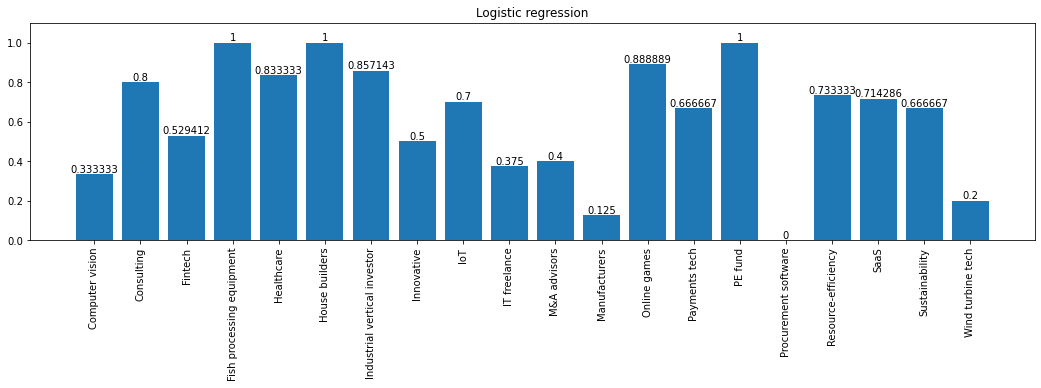

In [150]:
_, _ = plot_accuracies(accuracies, "Logistic regression")
plt.show()

In [8]:
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

NameError: name 'preds' is not defined

#### XGBoost

In [158]:
accuracies = {}

for file_name in tqdm(file_names):
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X_train, y_train, X_test, y_test = dfc.get_feature_vectors(split=True)

    xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xg.fit(X_train, y_train)
    
    accuracies[file_name] = sum(xg.predict(X_test) == y_test) / len(y_test)

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


In [159]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies.values())

Average accuracy: 0.5674649859943977
---
dict_values([0.3333333333333333, 0.8, 0.058823529411764705, 1.0, 0.5, 0.5, 0.14285714285714285, 0.5, 1.0, 0.125, 0.6, 0.25, 1.0, 0.6666666666666666, 0.625, 0.0, 0.7333333333333333, 0.7142857142857143, 1.0, 0.8])


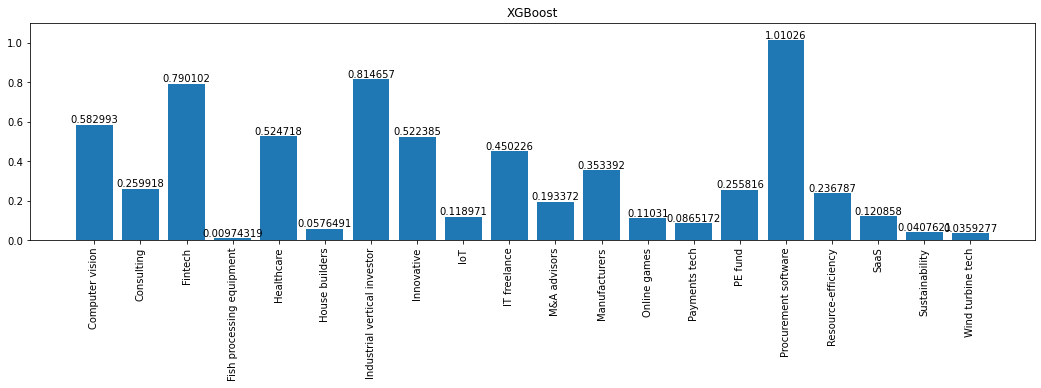

In [9]:
_, _ = plot_accuracies(accuracies, "XGBoost")
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Train one file, test on all others individually

#### Logistic

In [168]:

dfcs = {}
feature_vectors = {}
accuracies = [[] for _ in range(len(file_names))]

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    feature_vectors[file_name] = dfcs[file_name].get_feature_vectors(split=False)


# Calculate the accuracies
for i, train_file in tqdm(enumerate(file_names)):

    X_train, y_train = feature_vectors[train_file]
    clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False).fit(X_train, y_train)

    for test_file in file_names:
        X_test, y_test = feature_vectors[test_file]
        accuracies[i].append(clf.score(X_test,y_test))

100%|██████████| 20/20 [00:00<00:00, 39.36it/s]
20it [00:00, 230.98it/s]


In [169]:
avg_accuracies = [np.mean(x) for x in accuracies]
acc = dict(zip(file_names, avg_accuracies))

In [170]:
print(f"Average accuracy: {np.mean(list(acc.values()))}")
print("---")
print(acc.values())

Average accuracy: 0.5171337064813073
---
dict_values([0.5060298328684383, 0.5001670286379258, 0.5620443462168352, 0.5217110158044327, 0.5151688724927889, 0.5111893310820543, 0.5239685138780003, 0.5204118624559071, 0.5090578972714142, 0.4834928911965465, 0.4933172867286961, 0.5403529383506717, 0.5190655344243302, 0.5155736890004055, 0.5437222829528899, 0.5336663989282702, 0.51989611394357, 0.5191416953176755, 0.5004041832180499, 0.5042924148572453])


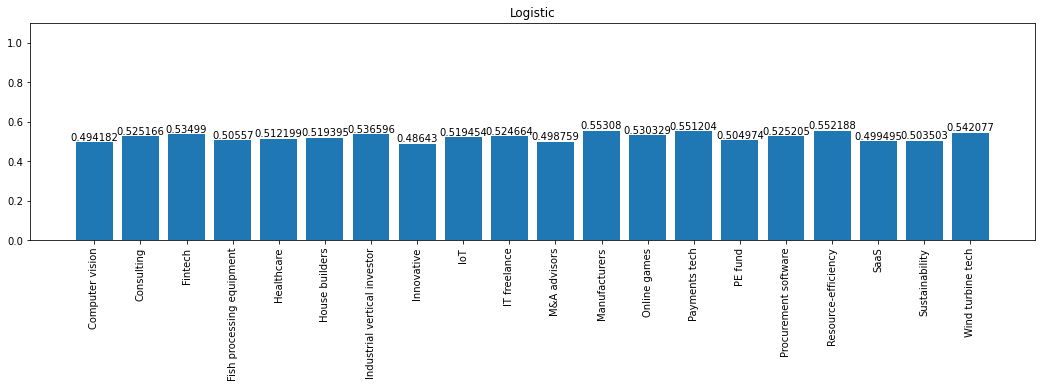

In [11]:
_,_ = plot_accuracies(acc, "Logistic")
plt.show()

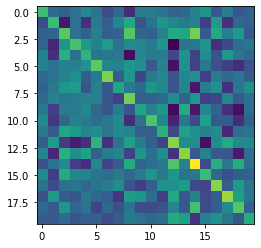

In [171]:
plt.imshow(accuracies)

#### XGBoost

In [176]:
dfcs = {}
feature_vectors = {}
accuracies = [[] for _ in range(len(file_names))]

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    feature_vectors[file_name] = dfcs[file_name].get_tfidf_vectors(split=False)

# Calculate the accuracies
for i, train_file in tqdm(enumerate(file_names)):

    X_train, y_train = feature_vectors[train_file]

    for test_file in file_names:
        X_test, y_test = feature_vectors[test_file]

        xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        xg.fit(X_train, y_train)

        accuracies[i].append(sum(xg.predict(X_test) == y_test) / len(y_test))

100%|██████████| 20/20 [00:00<00:00, 35.92it/s]
20it [00:10,  1.88it/s]


In [177]:
avg_accuracies = [np.mean(x) for x in accuracies]
acc = dict(zip(file_names, avg_accuracies))

In [178]:
print(f"Average accuracy: {np.mean(list(acc.values()))}")
print("---")
print(acc.values())

Average accuracy: 0.526624757197576
---
dict_values([0.48710051096044865, 0.5548008475762068, 0.5358141908980335, 0.5216253091873269, 0.48566820805579064, 0.508559408316973, 0.5037298553521178, 0.525061395175368, 0.5430351826492195, 0.5044178052100767, 0.49353101930699805, 0.5361008960181334, 0.5514823227096567, 0.5463651356238335, 0.5623682099410506, 0.4787565779483379, 0.5544723608949078, 0.52802301670938, 0.5496701858311698, 0.5619127055864912])


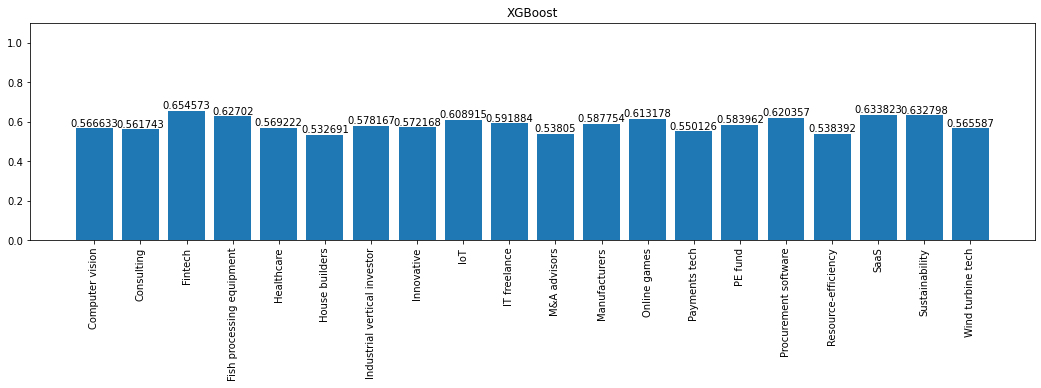

In [ ]:
_,_ = plot_accuracies(acc, "XGBoost")
plt.show()

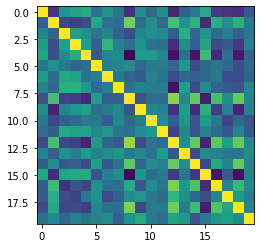

In [179]:
plt.imshow(accuracies)

## Train all files except one, test on the last

#### Logistic

In [184]:
dfcs = {}
accuracies = {}
feature_vectors = {}

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    feature_vectors[file_name] = dfcs[file_name].get_feature_vectors(split=False)

# Calculate the accuracies
for test_file in tqdm(file_names):

    X_train, y_train = [], []
    X_test, y_test = feature_vectors[test_file]
    
    for train_file in file_names:
        if train_file == test_file:
            continue
        new_X_train, new_y_train = feature_vectors[train_file]
        X_train.extend(new_X_train)
        y_train.extend(new_y_train)
        
    clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)
    accuracies[test_file] = clf.score(X_test, y_test)

100%|██████████| 20/20 [00:00<00:00, 52.25it/s]


In [185]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies.values())

Average accuracy: 0.5818682528373648
---
dict_values([0.6052631578947368, 0.7377049180327869, 0.417910447761194, 0.7101449275362319, 0.7444444444444445, 0.6785714285714286, 0.6086956521739131, 0.6447368421052632, 0.5483870967741935, 0.39344262295081966, 0.6071428571428571, 0.5972222222222222, 0.7666666666666667, 0.5, 0.6176470588235294, 0.5901639344262295, 0.2857142857142857, 0.43636363636363634, 0.54, 0.6071428571428571])


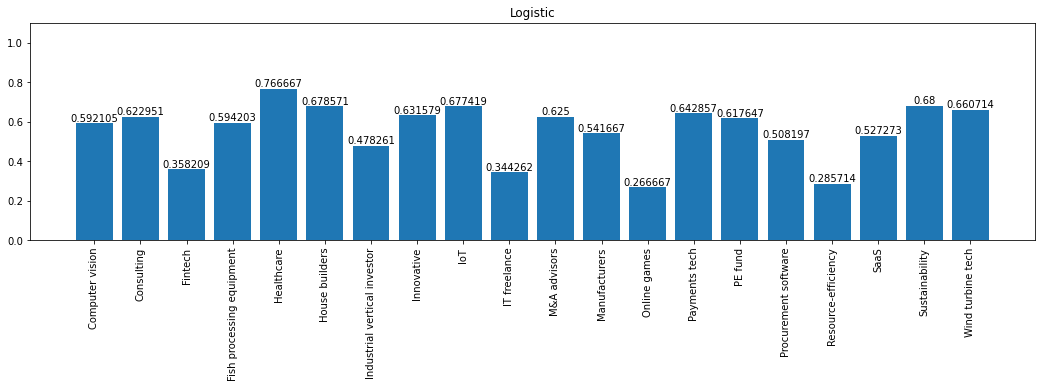

In [ ]:
_,_ = plot_accuracies(accuracies, "Logistic")
plt.show()

#### XGBoost

In [188]:
dfcs = {}
accuracies = {}
feature_vectors = {}

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    feature_vectors[file_name] = dfcs[file_name].get_tfidf_vectors(split=False)


# Calculate the accuracies
for test_file in tqdm(file_names):

    X_train, y_train = [], []
    X_test, y_test = feature_vectors[test_file]
    
    for train_file in file_names:
        if train_file == test_file:
            continue
        new_X_train, new_y_train = feature_vectors[train_file]
        X_train.extend(new_X_train)
        y_train.extend(new_y_train)
        
    xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xg.fit(X_train, y_train)
    
    accuracies[test_file] = sum(xg.predict(X_test) == y_test) / len(y_test)

100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


In [189]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies.values())

Average accuracy: 0.5154780533815915
---
dict_values([0.42105263157894735, 0.4918032786885246, 0.6716417910447762, 0.5217391304347826, 0.5777777777777777, 0.4107142857142857, 0.5217391304347826, 0.5394736842105263, 0.5161290322580645, 0.4262295081967213, 0.42857142857142855, 0.625, 0.35, 0.6857142857142857, 0.5294117647058824, 0.4098360655737705, 0.5428571428571428, 0.4727272727272727, 0.56, 0.6071428571428571])


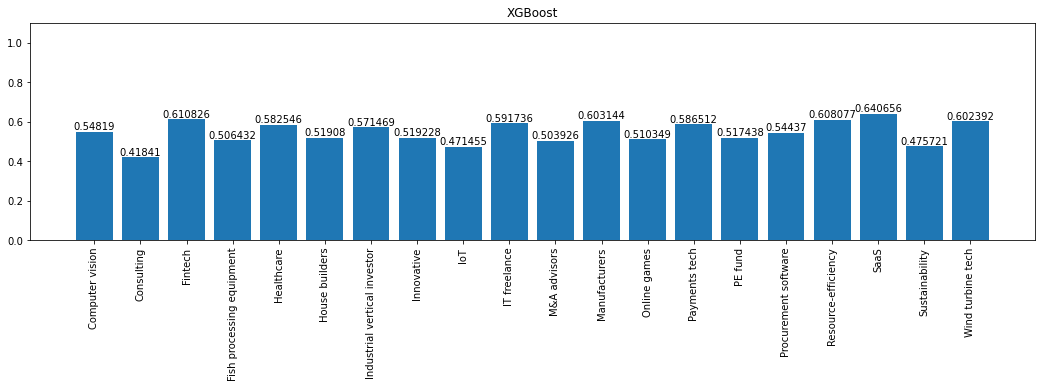

In [ ]:
_,_ = plot_accuracies(accuracies, "XGBoost")
plt.show()

# Crossvalidation 

## XGBoost

### Train

In [15]:

dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train, y_train = dfc.get_feature_vectors(split=False)

dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test, y_test = dfc.get_feature_vectors(split=False)

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, {
    'booster' : ['gbtree', 'gblinear', 'dart'],
    'n_estimators' : [1, 5, 10, 20, 50],
    # 'gamma' : [0, 2, 5],
    # 'max_depth' : [2,4,10,12]
    }, 
    verbose=1,
    n_jobs=2
)
clf.fit(X_train, y_train)
print(f"Best score: {clf.best_score_}")
print(f"Best params: {clf.best_params_}")

* Reading CSV from path: data/train/Computer vision.csv. Size: (201, 3)
Initializing DataFrameFeatures object
* Reading CSV from path: data/train/Consulting.csv. Size: (182, 3)
Initializing DataFrameFeatures object
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best score: -0.21432124557678894
Best params: {'booster': 'gblinear', 'n_estimators': 1}


### Test

In [39]:
from sklearn.metrics import accuracy_score

xg_reg = xgb.XGBRegressor()#booster = 'gblinear', n_estimators = 1)
xg_reg.fit(X_train, y_train)
xg_reg.score(X_test,y_test)

threshold = 0.6

for i in range(0,10):
    threshold = i * 0.1
    preds = xg_reg.predict(X_test)
    preds = (threshold <= preds).astype(int)

    print(i, accuracy_score(y_test,preds))
# score = np.sqrt(mean_squared_error(y_test, preds))
# score

0 0.7377049180327869
1 0.7377049180327869
2 0.7213114754098361
3 0.6721311475409836
4 0.639344262295082
5 0.6065573770491803
6 0.5245901639344263
7 0.45901639344262296
8 0.39344262295081966
9 0.2786885245901639


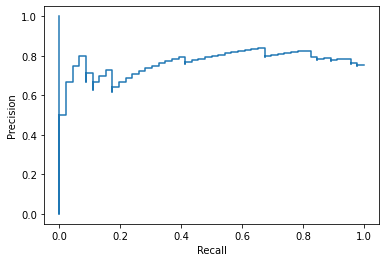

In [41]:
preds = xg_reg.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [43]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
metrics.auc(fpr, tpr)

0.572463768115942

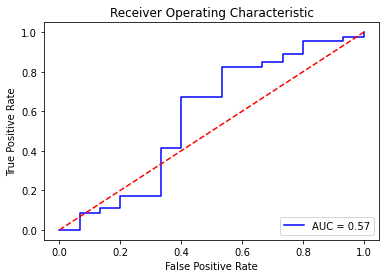

In [47]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

buildROC(y_test,preds)

In [ ]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting', verbose=False)
dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='SaaS', verbose=False)

X_train, y_train = dfc1.get_tfidf_vectors()
X_test, y_test = dfc2.get_tfidf_vectors()

xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='map')
xg.fit(X_train, y_train)

preds = xg.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, preds)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)

disp.plot()

In [208]:
p = []
n = []
t = []
for file in file_names:
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file, verbose=False)
    X, y = dfc.get_feature_vectors(split=False)
    p.append(sum(y))
    t.append(len(y))
    n.append(len(y)-sum(y))

print(p)
print(n)
print(t)

[27.0, 46.0, 21.0, 20.0, 23.0, 35.0, 19.0, 30.0, 55.0, 22.0, 27.0, 35.0, 53.0, 39.0, 27.0, 12.0, 56.0, 35.0, 41.0, 30.0]
[49.0, 15.0, 46.0, 49.0, 67.0, 21.0, 27.0, 46.0, 7.0, 39.0, 29.0, 37.0, 7.0, 31.0, 7.0, 49.0, 14.0, 20.0, 9.0, 26.0]
[76, 61, 67, 69, 90, 56, 46, 76, 62, 61, 56, 72, 60, 70, 34, 61, 70, 55, 50, 56]


In [206]:
print(initials)

[3.0, 5.0, 16.0, 1.0, 6.0, 4.0, 7.0, 6.0, 10.0, 8.0, 5.0, 8.0, 9.0, 9.0, 8.0, 2.0, 15.0, 7.0, 3.0, 5.0]
